In [1]:
%matplotlib inline

In [2]:
import os
dirname = "/Users/aphearin/Dropbox/protoDC2"
sdss_basename = "volume_complete_sdss.hdf5"
umachine_z0_basename = "value_added_umachine_sfr_catalog_1.002310.hdf5"
umachine_z1_basename = "value_added_umachine_sfr_catalog_0.501122.hdf5"
protoDC2_basename = "value_added_protoDC2_snapnum_487.hdf5"

from astropy.table import Table
sdss = Table.read(os.path.join(dirname, sdss_basename), path='data')
umachine_z0 = Table.read(os.path.join(dirname, umachine_z0_basename), path='data')
umachine_z1 = Table.read(os.path.join(dirname, umachine_z1_basename), path='data')
protoDC2_z0 = Table.read(os.path.join(dirname, protoDC2_basename), path='data')

print(protoDC2_z0.keys())

['totalLuminositiesStellar:SDSS_r:observed', 'diskLuminositiesStellar:SDSS_r:observed', 'spheroidLuminositiesStellar:SDSS_r:observed', 'totalLuminositiesStellar:SDSS_g:observed', 'diskLuminositiesStellar:SDSS_g:observed', 'spheroidLuminositiesStellar:SDSS_g:observed', 'infallHaloMass', 'hostHaloMass', 'hostIndex', 'isCentral', 'spheroidMassStellar', 'totalMassStellar', 'galaxyID', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'totalStarFormationRate', 'mstar_percentile_fixed_infallHaloMass']


In [4]:
from scipy.stats import binned_statistic

umachine_z0_mpeak_min, umachine_z0_mpeak_max = umachine_z0['mpeak'].min(), umachine_z0['mpeak'].max()
umachine_z0_mpeak_bins = np.logspace(np.log10(umachine_z0_mpeak_min), np.log10(umachine_z0_mpeak_max), 25)
umachine_z0_mpeak_mids = 10**(0.5*(np.log10(umachine_z0_mpeak_bins[:-1]) + np.log10(umachine_z0_mpeak_bins[1:])))

umachine_z1_mpeak_min, umachine_z1_mpeak_max = umachine_z1['mpeak'].min(), umachine_z1['mpeak'].max()
umachine_z1_mpeak_bins = np.logspace(np.log10(umachine_z1_mpeak_min), np.log10(umachine_z1_mpeak_max), 30)
umachine_z1_mpeak_mids = 10**(0.5*(np.log10(umachine_z1_mpeak_bins[:-1]) + np.log10(umachine_z1_mpeak_bins[1:])))

median_logsm_umachine_z0, bins, __ = binned_statistic(
    umachine_z0['mpeak'], np.log10(umachine_z0['obs_sm']), 
    bins=umachine_z0_mpeak_bins, statistic='median')
median_logsm_umachine_z1, bins, __ = binned_statistic(
    umachine_z1['mpeak'], np.log10(umachine_z1['obs_sm']), 
    bins=umachine_z1_mpeak_bins, statistic='median')


std_logsm_umachine_z0, bins, __ = binned_statistic(
    umachine_z0['mpeak'], np.log10(umachine_z0['obs_sm']), 
    bins=umachine_z0_mpeak_bins, statistic=np.std)
std_logsm_umachine_z1, bins, __ = binned_statistic(
    umachine_z1['mpeak'], np.log10(umachine_z1['obs_sm']), 
    bins=umachine_z1_mpeak_bins, statistic=np.std)

protoDC2_z0_mpeak_min, protoDC2_z0_mpeak_max = protoDC2_z0['infallHaloMass'].min(), protoDC2_z0['infallHaloMass'].max()
protoDC2_z0_mpeak_bins = np.logspace(np.log10(protoDC2_z0_mpeak_min), np.log10(protoDC2_z0_mpeak_max), 30)
protoDC2_z0_mpeak_mids = 10**(0.5*(np.log10(protoDC2_z0_mpeak_bins[:-1]) + np.log10(protoDC2_z0_mpeak_bins[1:])))
median_logsm_protoDC2_z0, bins, __ = binned_statistic(
    protoDC2_z0['infallHaloMass'], np.log10(protoDC2_z0['totalMassStellar']), 
    bins=protoDC2_z0_mpeak_bins, statistic='median')


In [77]:
from scipy.stats import norm 

u = protoDC2_z0['mstar_percentile_fixed_infallHaloMass']

bad_umask = protoDC2_z0['infallHaloMass'] > 10**13.75

randoms = np.random.random(len(u))
u = np.where(bad_umask, randoms, u)

loc = np.interp(np.log10(protoDC2_z0['infallHaloMass']), 
                np.log10(umachine_z0_mpeak_mids), median_logsm_umachine_z0)
std = np.interp(np.log10(protoDC2_z0['infallHaloMass']), 
                np.log10(umachine_z0_mpeak_mids), std_logsm_umachine_z0)
std = 0.2
protoDC2_z0['rescaled_mstar'] = 10**norm.isf(1. - u, loc, std)

median_logsm_remapped_protodc2, bins, __ = binned_statistic(
    protoDC2_z0['infallHaloMass'], np.log10(protoDC2_z0['rescaled_mstar']), 
    bins=protoDC2_z0_mpeak_bins, statistic='median')

std_logsm_remapped_protodc2, bins, __ = binned_statistic(
    protoDC2_z0['infallHaloMass'], np.log10(protoDC2_z0['rescaled_mstar']), 
    bins=protoDC2_z0_mpeak_bins, statistic=np.std)


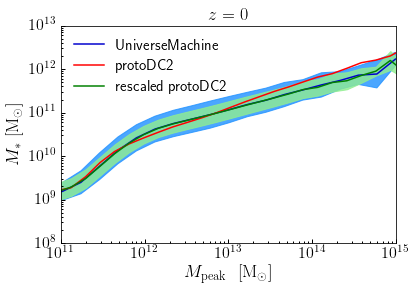

In [78]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()

y1 = 10**(median_logsm_umachine_z0 - std_logsm_umachine_z0)
y2 = 10**(median_logsm_umachine_z0 + std_logsm_umachine_z0)
__=ax.fill_between(umachine_z0_mpeak_mids, y1, y2, color='dodgerblue', alpha=0.8)
__=ax.plot(umachine_z0_mpeak_mids, 10**median_logsm_umachine_z0, color='mediumblue', label='UniverseMachine')

__=ax.plot(protoDC2_z0_mpeak_mids, 10**median_logsm_protoDC2_z0, color='red', label='protoDC2')

y1 = 10**(median_logsm_remapped_protodc2 - std_logsm_remapped_protodc2)
y2 = 10**(median_logsm_remapped_protodc2 + std_logsm_remapped_protodc2)
__=ax.fill_between(protoDC2_z0_mpeak_mids, y1, y2, color='lightgreen', alpha=0.8)
__=ax.plot(protoDC2_z0_mpeak_mids, 10**median_logsm_remapped_protodc2, color='green', label='rescaled protoDC2')

xlim = ax.set_xlim(1e11, 1e15)
ylim = ax.set_ylim(1e8, 1e13)
legend = ax.legend()
xlabel = ax.set_xlabel(r'$M_{\rm peak}\ \ [{\rm M_{\odot}}]$')
ylabel = ax.set_ylabel(r'$M_{\ast}\ [{\rm M_{\odot}}]$')
title = ax.set_title(r'$z = 0$')

figname = 'smhm_protoDC2_vs_umachine.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

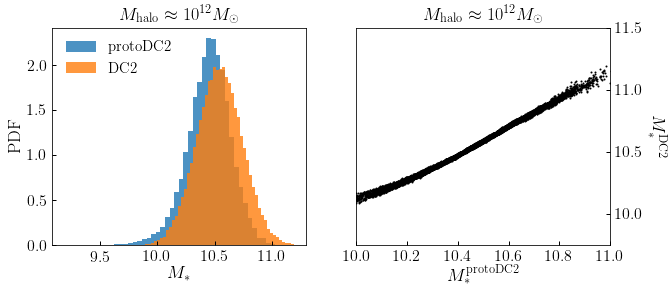

In [97]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(10, 4))

__=ax1.scatter(np.log10(protoDC2_z0['totalMassStellar'][mpeak_mask]), 
             np.log10(protoDC2_z0['rescaled_mstar'][mpeak_mask]), s=1, color='k')
xlim1 = ax1.set_xlim(10, 11)
ylim1 = ax1.set_ylim(9.75, 11.5)
xlabel1 = ax1.set_xlabel(r'$M_{\ast}^{\rm protoDC2}$')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()

ylabel1 = ax1.set_ylabel(r'$M_{\ast}^{\rm DC2}$', rotation=-90, labelpad=20)
title1 = ax1.set_title(r'$M_{\rm halo}\approx10^{12}M_{\odot}$')

__=ax2.hist(np.log10(protoDC2_z0['totalMassStellar'][mpeak_mask]), 
           alpha=0.8, normed=True, bins=50, label=r'${\rm protoDC2}$')
__=ax2.hist(np.log10(protoDC2_z0['rescaled_mstar'][mpeak_mask]), 
           alpha=0.8, normed=True, bins=50, label=r'${\rm DC2}$')

xlabel2 = ax2.set_xlabel(r'$M_{\ast}$')
ylabel2 = ax2.set_ylabel(r'${\rm PDF}$')

title2 = ax2.set_title(r'$M_{\rm halo}\approx10^{12}M_{\odot}$')
legend2 = ax2.legend()